# Clusteranalyse der Schweizer Gemeinden

Diese Analyse gruppiert Schweizer Gemeinden basierend auf ihrem Abstimmungsverhalten.

**Methoden:**
1. K-Means Clustering
2. Hierarchisches Clustering (Ward)
3. DBSCAN (dichtebasiert)
4. Gaussian Mixture Models (GMM)

**Datengrundlage:** Rohdaten der Abstimmungen (Ja-Prozent pro Gemeinde und Vorlage)

**Visualisierung:** Im PCA-Raum (aus vorheriger Analyse)

---

## 1. Setup und Daten laden

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

# Plot-Einstellungen
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
sns.set_style('whitegrid')

# Datenbankverbindung
DB_PATH = '../data/processed/swiss_votings.db'
conn = sqlite3.connect(DB_PATH)

print("Setup abgeschlossen.")

Setup abgeschlossen.


In [2]:
# Abstimmungsdaten laden
query = """
SELECT 
    municipality_id,
    municipality_name,
    proposal_id,
    ja_prozent
FROM v_voting_results_analysis
WHERE ja_prozent IS NOT NULL
"""

df_raw = pd.read_sql_query(query, conn)
print(f"Rohdaten geladen: {len(df_raw):,} Zeilen")

# Pivot-Tabelle erstellen: Gemeinden x Vorlagen
df_pivot = df_raw.pivot_table(
    index=['municipality_id', 'municipality_name'],
    columns='proposal_id',
    values='ja_prozent',
    aggfunc='first'
)

print(f"Matrix: {df_pivot.shape[0]} Gemeinden × {df_pivot.shape[1]} Vorlagen")

Rohdaten geladen: 471,595 Zeilen
Matrix: 2121 Gemeinden × 223 Vorlagen


In [3]:
# Datenbereinigung: Gemeinden/Vorlagen mit zu vielen fehlenden Werten entfernen
MAX_MISSING_RATIO = 0.20

# Vorlagen filtern
missing_per_proposal = df_pivot.isnull().sum(axis=0)
valid_proposals = missing_per_proposal[missing_per_proposal <= df_pivot.shape[0] * MAX_MISSING_RATIO].index
df_filtered = df_pivot[valid_proposals]

# Gemeinden filtern
missing_per_municipality = df_filtered.isnull().sum(axis=1)
valid_municipalities = missing_per_municipality[missing_per_municipality <= df_filtered.shape[1] * MAX_MISSING_RATIO].index
df_filtered = df_filtered.loc[valid_municipalities]

print(f"Nach Filterung: {df_filtered.shape[0]} Gemeinden × {df_filtered.shape[1]} Vorlagen")

# Imputation: Fehlende Werte mit Spalten-Mittelwert füllen
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(df_filtered)

# DataFrame für Referenz
df_imputed = pd.DataFrame(X_imputed, index=df_filtered.index, columns=df_filtered.columns)

# Standardisierung
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_imputed)

print(f"Daten standardisiert. Shape: {X_scaled.shape}")

Nach Filterung: 2109 Gemeinden × 223 Vorlagen
Daten standardisiert. Shape: (2109, 223)


In [4]:
# PCA für Visualisierung (aus vorheriger Analyse)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# PCA-Scores als DataFrame
df_pca = pd.DataFrame(
    X_pca,
    columns=['PC1', 'PC2', 'PC3'],
    index=df_imputed.index
).reset_index()

print(f"PCA berechnet. Erklärte Varianz: {pca.explained_variance_ratio_.sum()*100:.1f}%")
print(f"  PC1: {pca.explained_variance_ratio_[0]*100:.1f}%")
print(f"  PC2: {pca.explained_variance_ratio_[1]*100:.1f}%")
print(f"  PC3: {pca.explained_variance_ratio_[2]*100:.1f}%")

PCA berechnet. Erklärte Varianz: 59.0%
  PC1: 35.9%
  PC2: 14.1%
  PC3: 9.0%


## 2. Bestimmung der optimalen Clusteranzahl

In [5]:
# Elbow-Methode und Silhouette-Score für verschiedene k
k_range = range(2, 15)
inertias = []
silhouettes = []
calinski = []
davies = []

print("Berechne Metriken für k = 2 bis 14...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))
    calinski.append(calinski_harabasz_score(X_scaled, labels))
    davies.append(davies_bouldin_score(X_scaled, labels))

print("Fertig.")

Berechne Metriken für k = 2 bis 14...


Fertig.


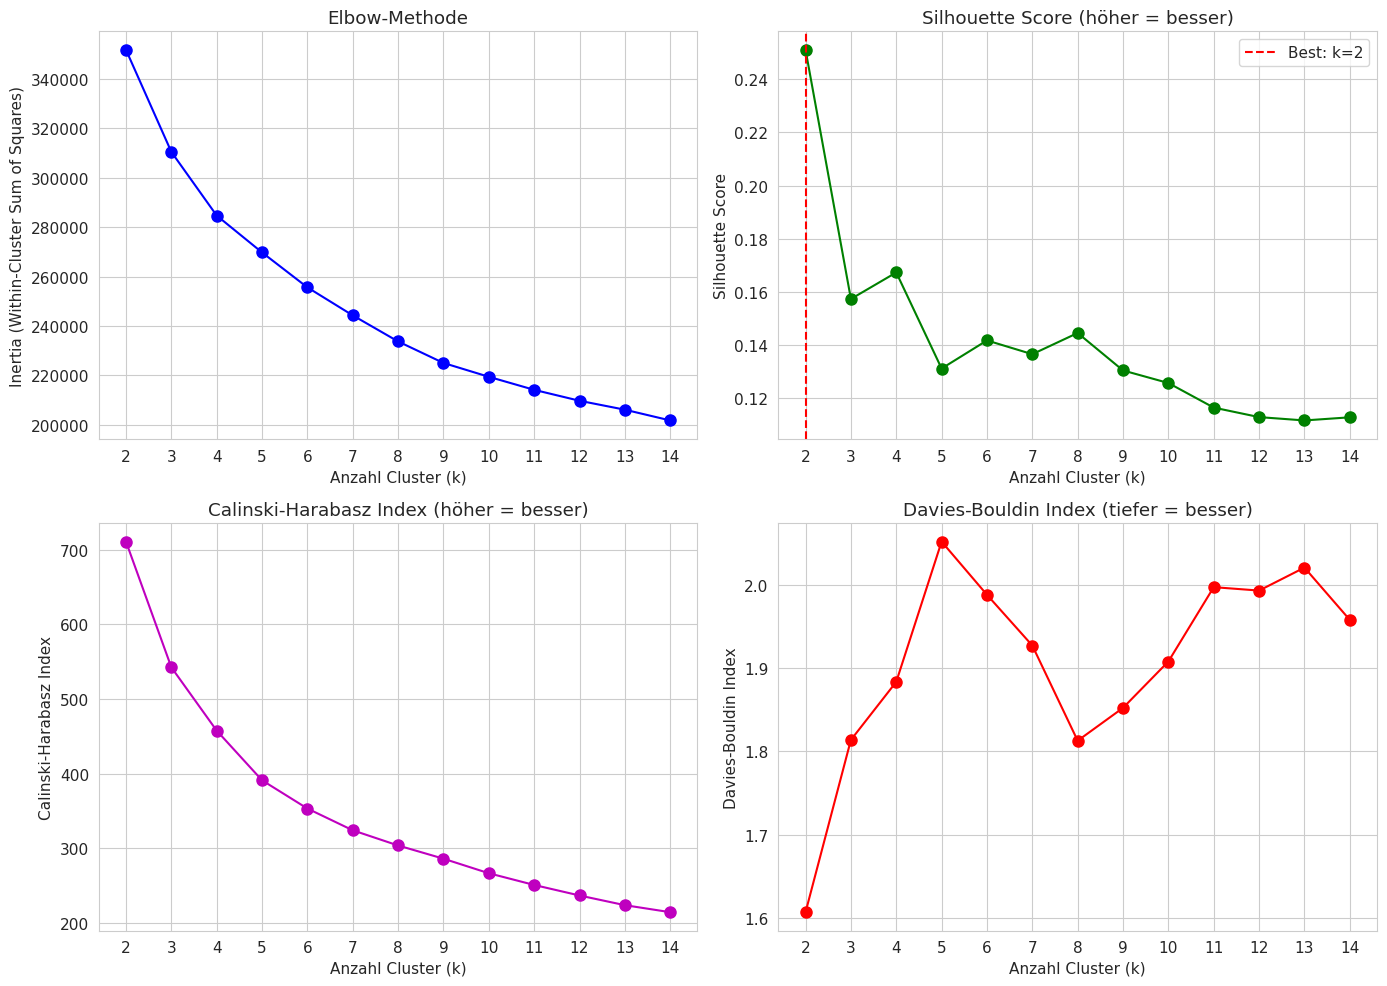


Bester Silhouette Score bei k = 2


In [6]:
# Visualisierung der Metriken
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Elbow (Inertia)
axes[0, 0].plot(k_range, inertias, 'bo-', markersize=8)
axes[0, 0].set_xlabel('Anzahl Cluster (k)')
axes[0, 0].set_ylabel('Inertia (Within-Cluster Sum of Squares)')
axes[0, 0].set_title('Elbow-Methode')
axes[0, 0].set_xticks(list(k_range))

# Silhouette Score (höher = besser)
axes[0, 1].plot(k_range, silhouettes, 'go-', markersize=8)
axes[0, 1].set_xlabel('Anzahl Cluster (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Score (höher = besser)')
axes[0, 1].set_xticks(list(k_range))
best_k_sil = list(k_range)[np.argmax(silhouettes)]
axes[0, 1].axvline(x=best_k_sil, color='red', linestyle='--', label=f'Best: k={best_k_sil}')
axes[0, 1].legend()

# Calinski-Harabasz Index (höher = besser)
axes[1, 0].plot(k_range, calinski, 'mo-', markersize=8)
axes[1, 0].set_xlabel('Anzahl Cluster (k)')
axes[1, 0].set_ylabel('Calinski-Harabasz Index')
axes[1, 0].set_title('Calinski-Harabasz Index (höher = besser)')
axes[1, 0].set_xticks(list(k_range))

# Davies-Bouldin Index (tiefer = besser)
axes[1, 1].plot(k_range, davies, 'ro-', markersize=8)
axes[1, 1].set_xlabel('Anzahl Cluster (k)')
axes[1, 1].set_ylabel('Davies-Bouldin Index')
axes[1, 1].set_title('Davies-Bouldin Index (tiefer = besser)')
axes[1, 1].set_xticks(list(k_range))

plt.tight_layout()
plt.savefig('cluster_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nBester Silhouette Score bei k = {best_k_sil}")

## 3. K-Means Clustering

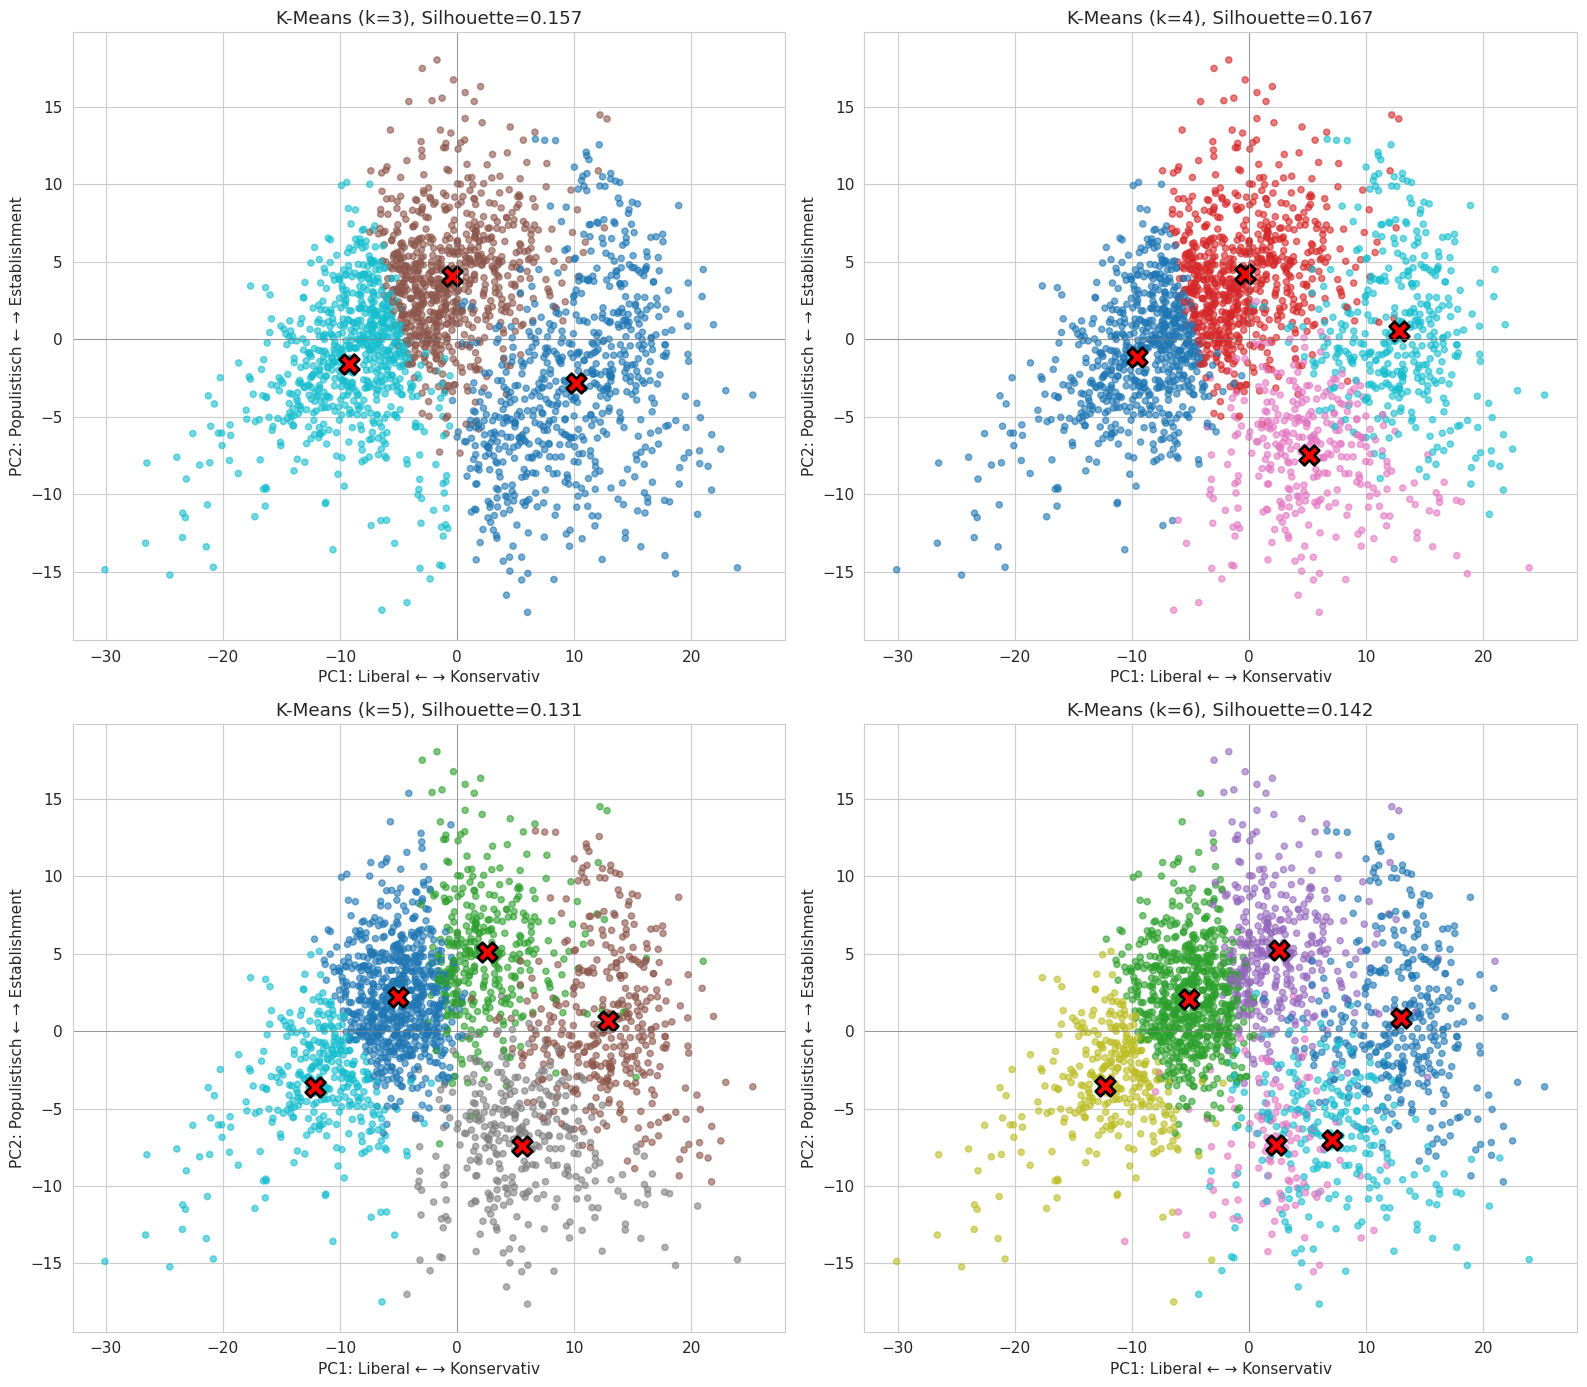

In [7]:
# K-Means mit verschiedenen k-Werten
k_values = [3, 4, 5, 6]

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

kmeans_results = {}

for i, k in enumerate(k_values):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    kmeans_results[k] = labels
    sil = silhouette_score(X_scaled, labels)
    
    # Visualisierung im PCA-Raum
    scatter = axes[i].scatter(
        df_pca['PC1'], df_pca['PC2'],
        c=labels, cmap='tab10', alpha=0.6, s=20
    )
    axes[i].set_xlabel('PC1: Liberal ← → Konservativ')
    axes[i].set_ylabel('PC2: Populistisch ← → Establishment')
    axes[i].set_title(f'K-Means (k={k}), Silhouette={sil:.3f}')
    axes[i].axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
    axes[i].axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
    
    # Cluster-Zentren im PCA-Raum
    centers_pca = pca.transform(kmeans.cluster_centers_)
    axes[i].scatter(centers_pca[:, 0], centers_pca[:, 1], 
                   c='red', marker='X', s=200, edgecolors='black', linewidths=2)

plt.tight_layout()
plt.savefig('kmeans_clustering.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# Detailanalyse K-Means mit k=4 (oder bestem k)
BEST_K = 4  # Anpassen basierend auf obiger Analyse

kmeans_best = KMeans(n_clusters=BEST_K, random_state=42, n_init=10)
df_pca['kmeans_cluster'] = kmeans_best.fit_predict(X_scaled)

print(f"K-Means Clustering mit k={BEST_K}")
print(f"Silhouette Score: {silhouette_score(X_scaled, df_pca['kmeans_cluster']):.3f}")
print(f"\nCluster-Grössen:")
print(df_pca['kmeans_cluster'].value_counts().sort_index())

# Beispiel-Gemeinden pro Cluster
print("\n" + "="*60)
print("BEISPIEL-GEMEINDEN PRO CLUSTER (K-Means)")
print("="*60)
for cluster in range(BEST_K):
    cluster_members = df_pca[df_pca['kmeans_cluster'] == cluster]
    print(f"\nCluster {cluster} ({len(cluster_members)} Gemeinden):")
    # Gemeinden nahe am Zentrum
    center = cluster_members[['PC1', 'PC2', 'PC3']].mean()
    cluster_members = cluster_members.copy()
    cluster_members['dist_to_center'] = np.sqrt(
        (cluster_members['PC1'] - center['PC1'])**2 + 
        (cluster_members['PC2'] - center['PC2'])**2
    )
    for _, row in cluster_members.nsmallest(5, 'dist_to_center').iterrows():
        print(f"  {row['municipality_name']}")

K-Means Clustering mit k=4
Silhouette Score: 0.167

Cluster-Grössen:
kmeans_cluster
0    673
1    717
2    329
3    390
Name: count, dtype: int64

BEISPIEL-GEMEINDEN PRO CLUSTER (K-Means)

Cluster 0 (673 Gemeinden):
  Wimmis
  St. Margrethen
  Erlen
  Schlatt (TG)
  Oberegg

Cluster 1 (717 Gemeinden):
  Wangen bei Olten
  Füllinsdorf
  Balm bei Günsberg
  Hauenstein-Ifenthal
  Zeiningen

Cluster 2 (329 Gemeinden):
  Siviriez
  Semsales
  Calanca
  Crésuz
  Les Montets

Cluster 3 (390 Gemeinden):
  Givisiez
  Bercher
  Daillens
  Aire-la-Ville
  Puidoux


## 4. Hierarchisches Clustering

Berechne hierarchisches Clustering (Ward-Methode)...


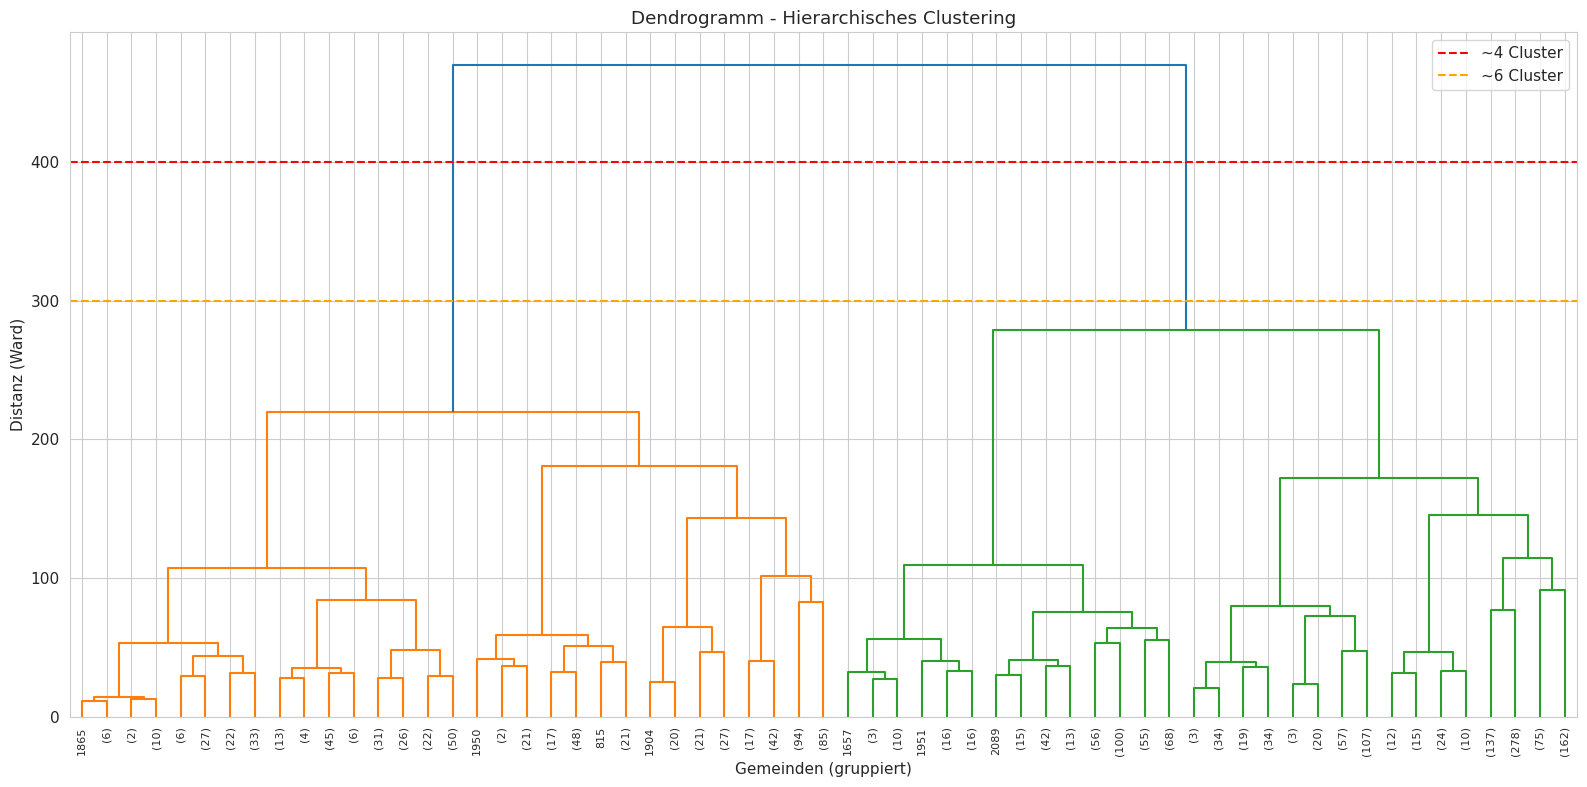

In [9]:
# Hierarchisches Clustering - Dendrogramm
print("Berechne hierarchisches Clustering (Ward-Methode)...")

# Linkage berechnen
Z = linkage(X_scaled, method='ward')

# Dendrogramm (nur obere Ebenen für Übersichtlichkeit)
fig, ax = plt.subplots(figsize=(16, 8))

dendrogram(
    Z,
    truncate_mode='level',
    p=5,  # Zeige nur 5 Ebenen
    leaf_rotation=90,
    leaf_font_size=8,
    ax=ax
)

ax.set_xlabel('Gemeinden (gruppiert)')
ax.set_ylabel('Distanz (Ward)')
ax.set_title('Dendrogramm - Hierarchisches Clustering')

# Horizontale Linien für verschiedene Cluster-Anzahlen
ax.axhline(y=400, color='red', linestyle='--', label='~4 Cluster')
ax.axhline(y=300, color='orange', linestyle='--', label='~6 Cluster')
ax.legend()

plt.tight_layout()
plt.savefig('hierarchical_dendrogram.png', dpi=150, bbox_inches='tight')
plt.show()

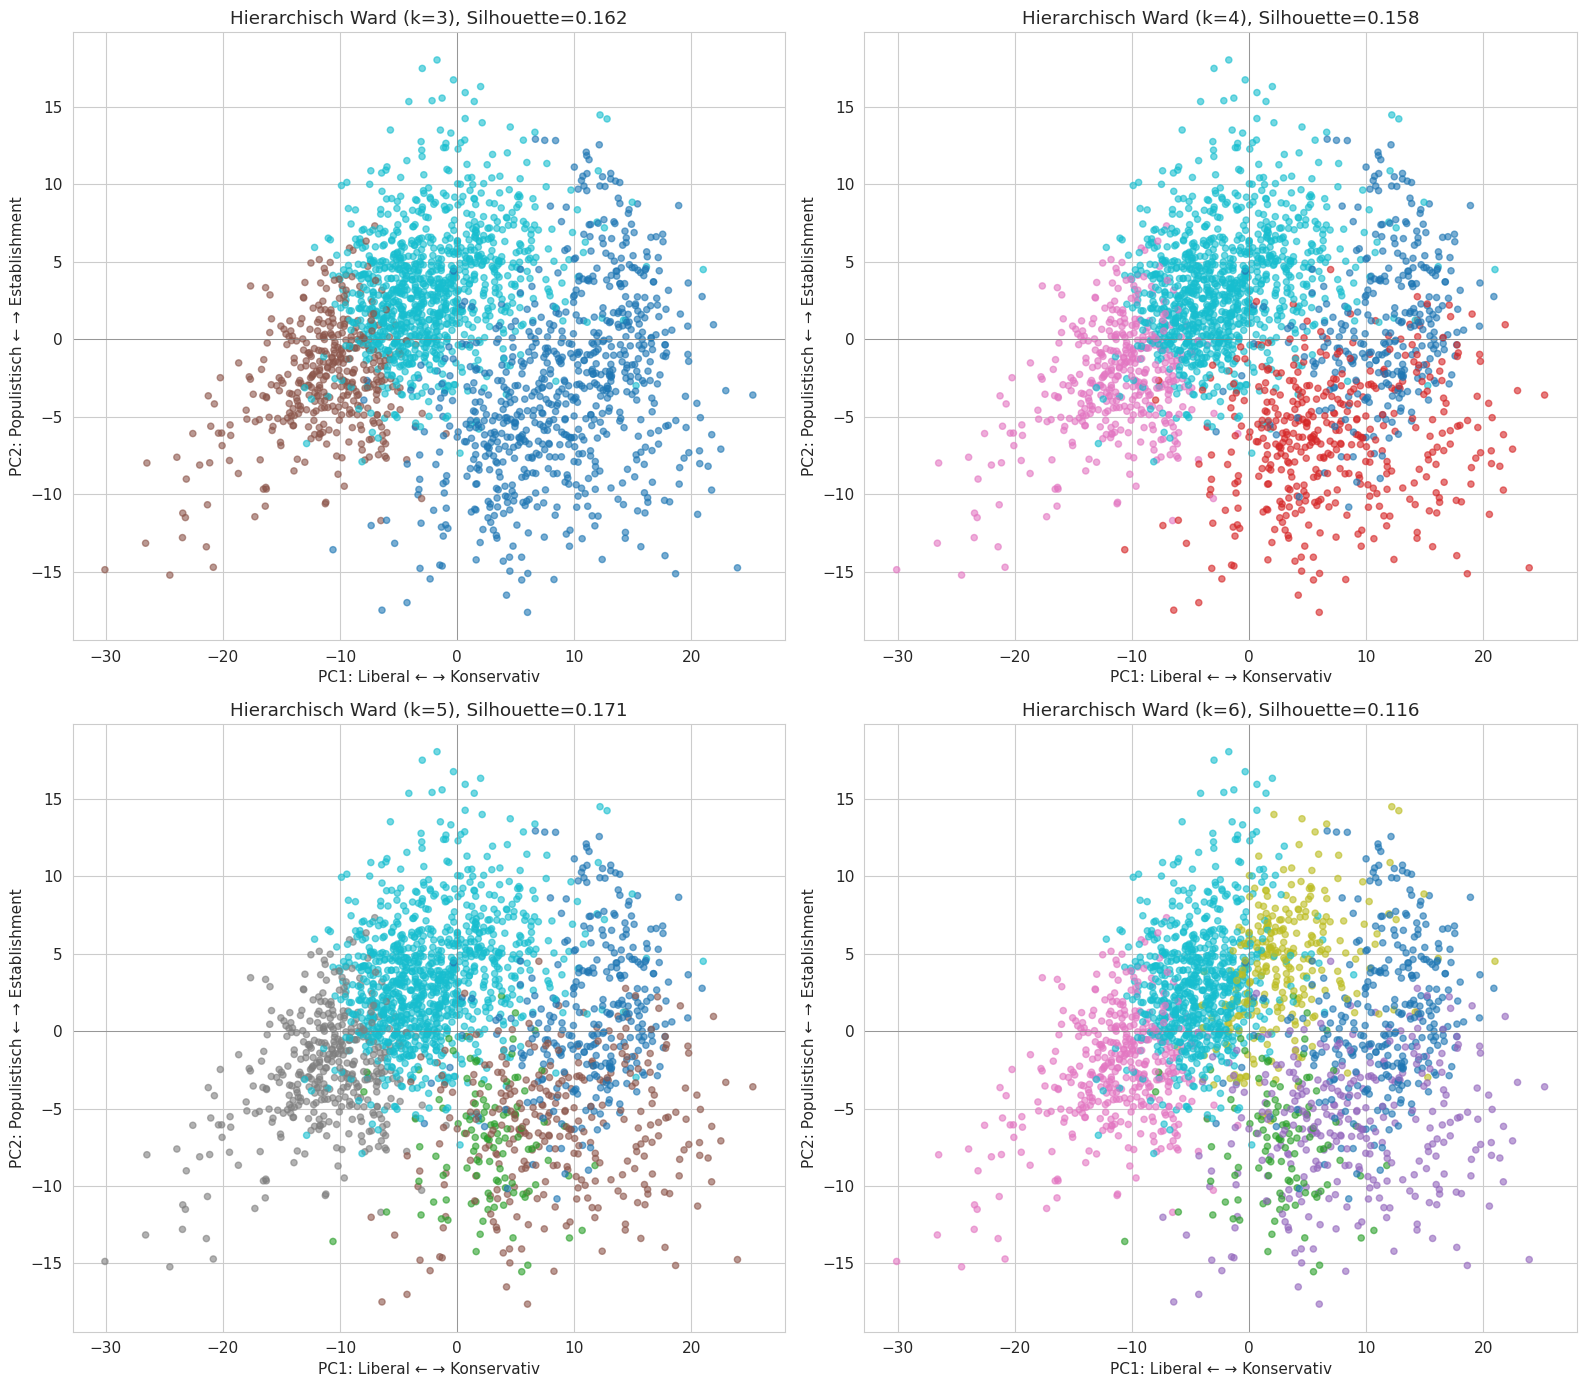

In [10]:
# Hierarchisches Clustering mit verschiedenen Cluster-Anzahlen
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

hier_results = {}

for i, k in enumerate(k_values):
    labels = fcluster(Z, k, criterion='maxclust') - 1  # 0-basiert
    hier_results[k] = labels
    sil = silhouette_score(X_scaled, labels)
    
    scatter = axes[i].scatter(
        df_pca['PC1'], df_pca['PC2'],
        c=labels, cmap='tab10', alpha=0.6, s=20
    )
    axes[i].set_xlabel('PC1: Liberal ← → Konservativ')
    axes[i].set_ylabel('PC2: Populistisch ← → Establishment')
    axes[i].set_title(f'Hierarchisch Ward (k={k}), Silhouette={sil:.3f}')
    axes[i].axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
    axes[i].axvline(x=0, color='gray', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('hierarchical_clustering.png', dpi=150, bbox_inches='tight')
plt.show()

In [11]:
# Hierarchisches Clustering - Detailanalyse
df_pca['hier_cluster'] = fcluster(Z, BEST_K, criterion='maxclust') - 1

print(f"Hierarchisches Clustering mit k={BEST_K}")
print(f"Silhouette Score: {silhouette_score(X_scaled, df_pca['hier_cluster']):.3f}")
print(f"\nCluster-Grössen:")
print(df_pca['hier_cluster'].value_counts().sort_index())

print("\n" + "="*60)
print("BEISPIEL-GEMEINDEN PRO CLUSTER (Hierarchisch)")
print("="*60)
for cluster in range(BEST_K):
    cluster_members = df_pca[df_pca['hier_cluster'] == cluster]
    print(f"\nCluster {cluster} ({len(cluster_members)} Gemeinden):")
    center = cluster_members[['PC1', 'PC2', 'PC3']].mean()
    cluster_members = cluster_members.copy()
    cluster_members['dist_to_center'] = np.sqrt(
        (cluster_members['PC1'] - center['PC1'])**2 + 
        (cluster_members['PC2'] - center['PC2'])**2
    )
    for _, row in cluster_members.nsmallest(5, 'dist_to_center').iterrows():
        print(f"  {row['municipality_name']}")

Hierarchisches Clustering mit k=4
Silhouette Score: 0.158

Cluster-Grössen:
hier_cluster
0    304
1    418
2    397
3    990
Name: count, dtype: int64

BEISPIEL-GEMEINDEN PRO CLUSTER (Hierarchisch)

Cluster 0 (304 Gemeinden):
  Longirod
  Bettens
  Eclépens
  Faoug
  Veytaux

Cluster 1 (418 Gemeinden):
  Misery-Courtion
  Chalais
  Terre di Pedemonte
  Belmont-Broye
  Nods

Cluster 2 (397 Gemeinden):
  Hunzenschwil
  Wangen (SZ)
  Murgenthal
  Kaltbrunn
  Roggliswil

Cluster 3 (990 Gemeinden):
  Rapperswil (BE)
  Sumvitg
  Visp
  Steckborn
  Laufenburg


## 5. DBSCAN (Dichtebasiertes Clustering)

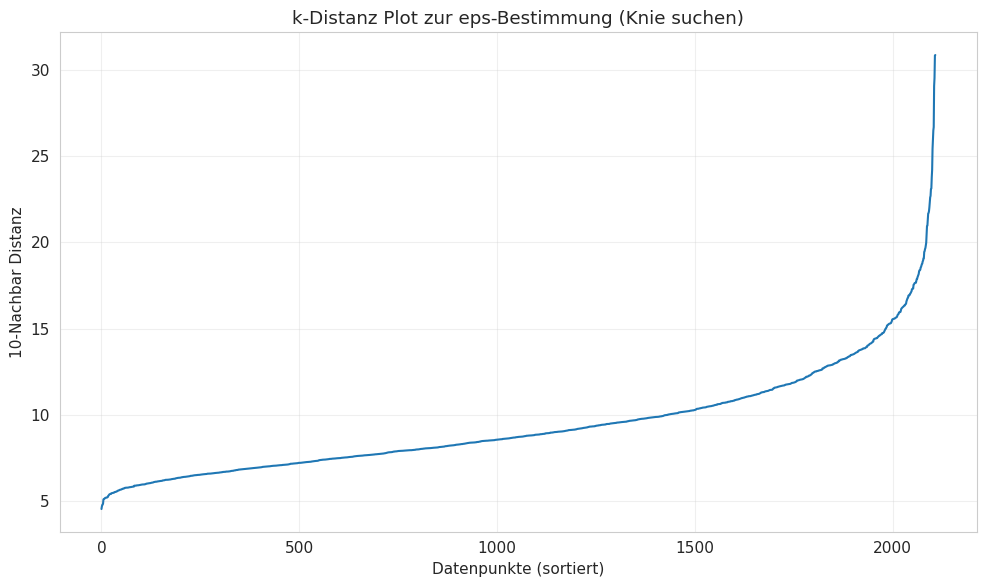

Empfohlener eps-Bereich: 13.5 - 15.6


In [12]:
# DBSCAN - Parameter-Suche
from sklearn.neighbors import NearestNeighbors

# k-Distanz Plot zur Bestimmung von eps
k = 10  # Anzahl Nachbarn
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X_scaled)
distances, _ = neigh.kneighbors(X_scaled)
distances = np.sort(distances[:, k-1])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(distances)
ax.set_xlabel('Datenpunkte (sortiert)')
ax.set_ylabel(f'{k}-Nachbar Distanz')
ax.set_title('k-Distanz Plot zur eps-Bestimmung (Knie suchen)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dbscan_kdist.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Empfohlener eps-Bereich: {distances[int(len(distances)*0.9)]:.1f} - {distances[int(len(distances)*0.95)]:.1f}")

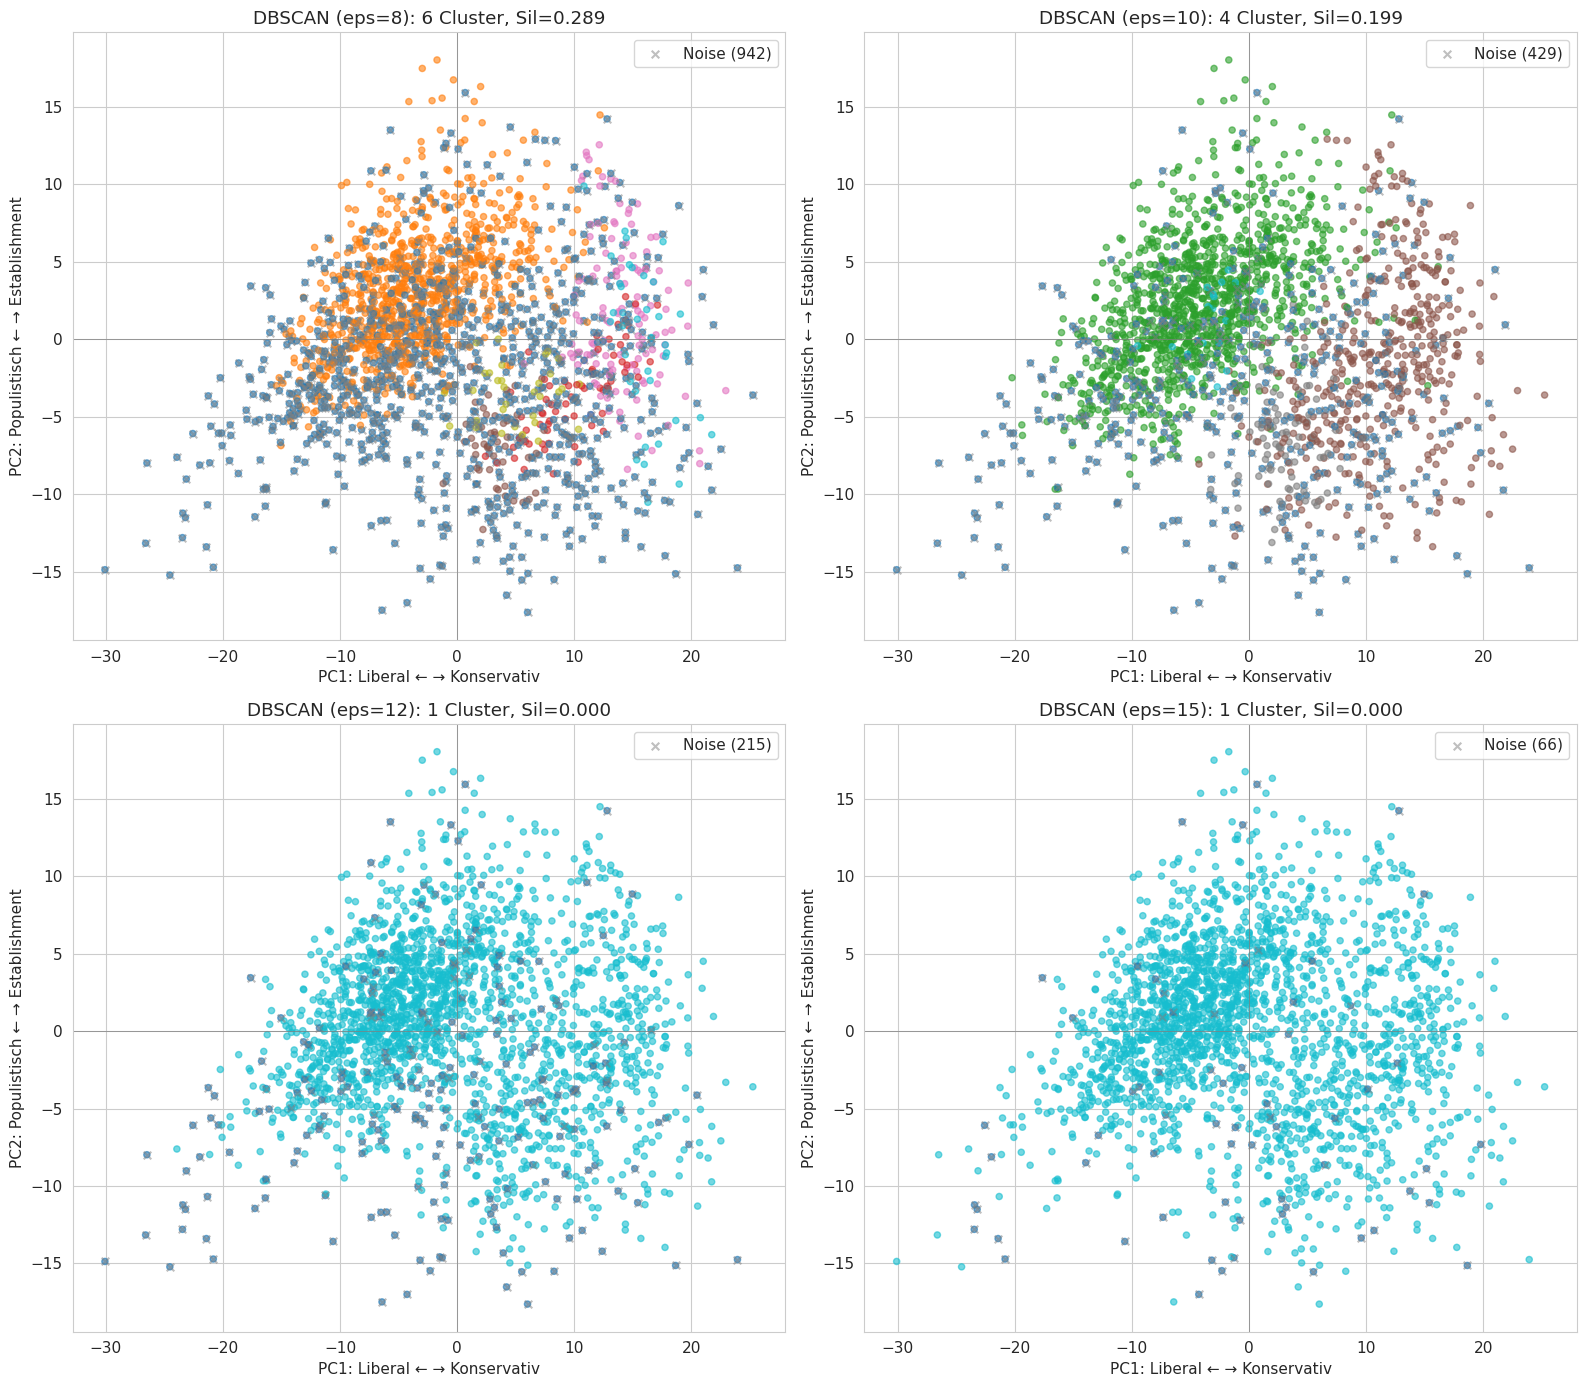

In [13]:
# DBSCAN mit verschiedenen eps-Werten
eps_values = [8, 10, 12, 15]
min_samples = 10

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

dbscan_results = {}

for i, eps in enumerate(eps_values):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)
    
    dbscan_results[eps] = labels
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = (labels == -1).sum()
    
    # Silhouette nur wenn > 1 Cluster
    if n_clusters > 1:
        # Ohne Noise-Punkte
        mask = labels != -1
        if mask.sum() > n_clusters:
            sil = silhouette_score(X_scaled[mask], labels[mask])
        else:
            sil = 0
    else:
        sil = 0
    
    # Visualisierung
    scatter = axes[i].scatter(
        df_pca['PC1'], df_pca['PC2'],
        c=labels, cmap='tab10', alpha=0.6, s=20
    )
    # Noise-Punkte markieren
    noise_mask = labels == -1
    axes[i].scatter(
        df_pca.loc[noise_mask, 'PC1'], 
        df_pca.loc[noise_mask, 'PC2'],
        c='gray', marker='x', s=30, alpha=0.5, label=f'Noise ({n_noise})'
    )
    
    axes[i].set_xlabel('PC1: Liberal ← → Konservativ')
    axes[i].set_ylabel('PC2: Populistisch ← → Establishment')
    axes[i].set_title(f'DBSCAN (eps={eps}): {n_clusters} Cluster, Sil={sil:.3f}')
    axes[i].axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
    axes[i].axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
    axes[i].legend(loc='upper right')

plt.tight_layout()
plt.savefig('dbscan_clustering.png', dpi=150, bbox_inches='tight')
plt.show()

In [14]:
# DBSCAN Detailanalyse mit bestem eps
BEST_EPS = 12  # Anpassen basierend auf obiger Analyse

dbscan_best = DBSCAN(eps=BEST_EPS, min_samples=min_samples)
df_pca['dbscan_cluster'] = dbscan_best.fit_predict(X_scaled)

n_clusters = len(set(df_pca['dbscan_cluster'])) - (1 if -1 in df_pca['dbscan_cluster'].values else 0)
n_noise = (df_pca['dbscan_cluster'] == -1).sum()

print(f"DBSCAN mit eps={BEST_EPS}, min_samples={min_samples}")
print(f"Anzahl Cluster: {n_clusters}")
print(f"Noise-Punkte (Ausreisser): {n_noise}")
print(f"\nCluster-Grössen:")
print(df_pca['dbscan_cluster'].value_counts().sort_index())

# Ausreisser-Gemeinden
if n_noise > 0:
    print("\n" + "="*60)
    print(f"AUSREISSER-GEMEINDEN (Noise, n={n_noise})")
    print("="*60)
    outliers = df_pca[df_pca['dbscan_cluster'] == -1]
    for _, row in outliers.head(20).iterrows():
        print(f"  {row['municipality_name']} (PC1={row['PC1']:.1f}, PC2={row['PC2']:.1f})")

DBSCAN mit eps=12, min_samples=10
Anzahl Cluster: 1
Noise-Punkte (Ausreisser): 215

Cluster-Grössen:
dbscan_cluster
-1     215
 0    1894
Name: count, dtype: int64

AUSREISSER-GEMEINDEN (Noise, n=215)
  Gurtnellen (PC1=-11.3, PC2=-10.6)
  Hospental (PC1=-14.2, PC2=-4.9)
  Isenthal (PC1=-6.2, PC2=-1.7)
  Realp (PC1=-7.0, PC2=7.3)
  Spiringen (PC1=-21.3, PC2=-10.7)
  Unterschächen (PC1=-23.1, PC2=-9.0)
  Innerthal (PC1=-16.4, PC2=-10.8)
  Vorderthal (PC1=-24.5, PC2=-15.2)
  Alpthal (PC1=-26.6, PC2=-13.2)
  Illgau (PC1=-21.0, PC2=-5.6)
  Muotathal (PC1=-26.5, PC2=-8.0)
  Riemenstalden (PC1=-23.4, PC2=-11.2)
  Unteriberg (PC1=-30.1, PC2=-14.9)
  Prévondavaux (PC1=-1.3, PC2=-14.6)
  Le Châtelard (PC1=-3.3, PC2=-10.0)
  Grangettes (PC1=-1.0, PC2=-9.2)
  Jaun (PC1=-13.6, PC2=-7.7)
  Ferpicloz (PC1=1.4, PC2=-2.8)
  Pierrafortscha (PC1=7.0, PC2=4.5)
  Villarsel-sur-Marly (PC1=8.7, PC2=1.6)


## 6. Gaussian Mixture Models (GMM)

Berechne GMM für verschiedene Komponentenzahlen...


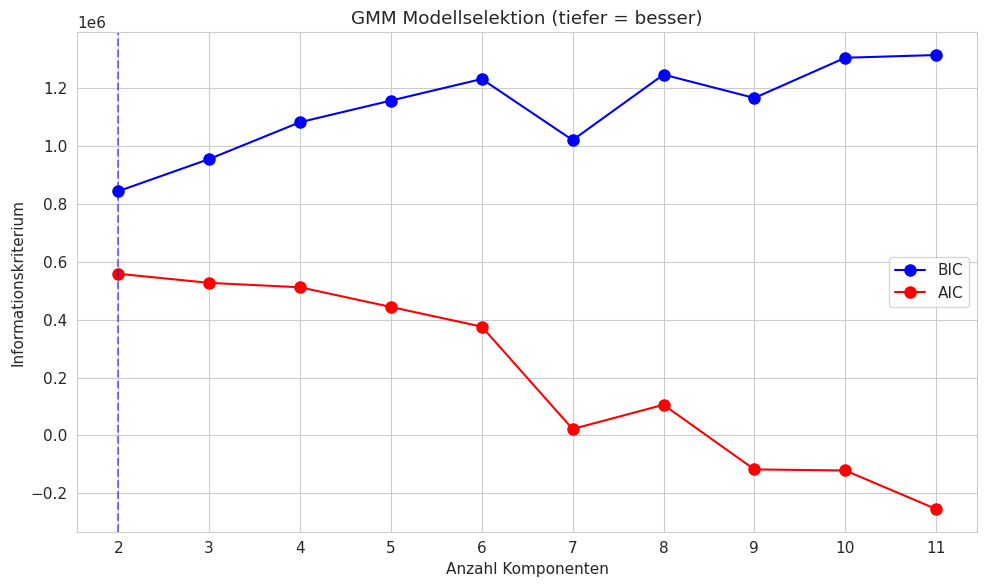


Optimale Komponentenzahl nach BIC: 2


In [15]:
# GMM - Modellselektion mit BIC/AIC
n_components_range = range(2, 12)
bics = []
aics = []

print("Berechne GMM für verschiedene Komponentenzahlen...")
for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42, n_init=5)
    gmm.fit(X_scaled)
    bics.append(gmm.bic(X_scaled))
    aics.append(gmm.aic(X_scaled))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(n_components_range, bics, 'bo-', label='BIC', markersize=8)
ax.plot(n_components_range, aics, 'ro-', label='AIC', markersize=8)
ax.set_xlabel('Anzahl Komponenten')
ax.set_ylabel('Informationskriterium')
ax.set_title('GMM Modellselektion (tiefer = besser)')
ax.legend()
ax.set_xticks(list(n_components_range))

best_n_bic = list(n_components_range)[np.argmin(bics)]
ax.axvline(x=best_n_bic, color='blue', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('gmm_model_selection.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nOptimale Komponentenzahl nach BIC: {best_n_bic}")

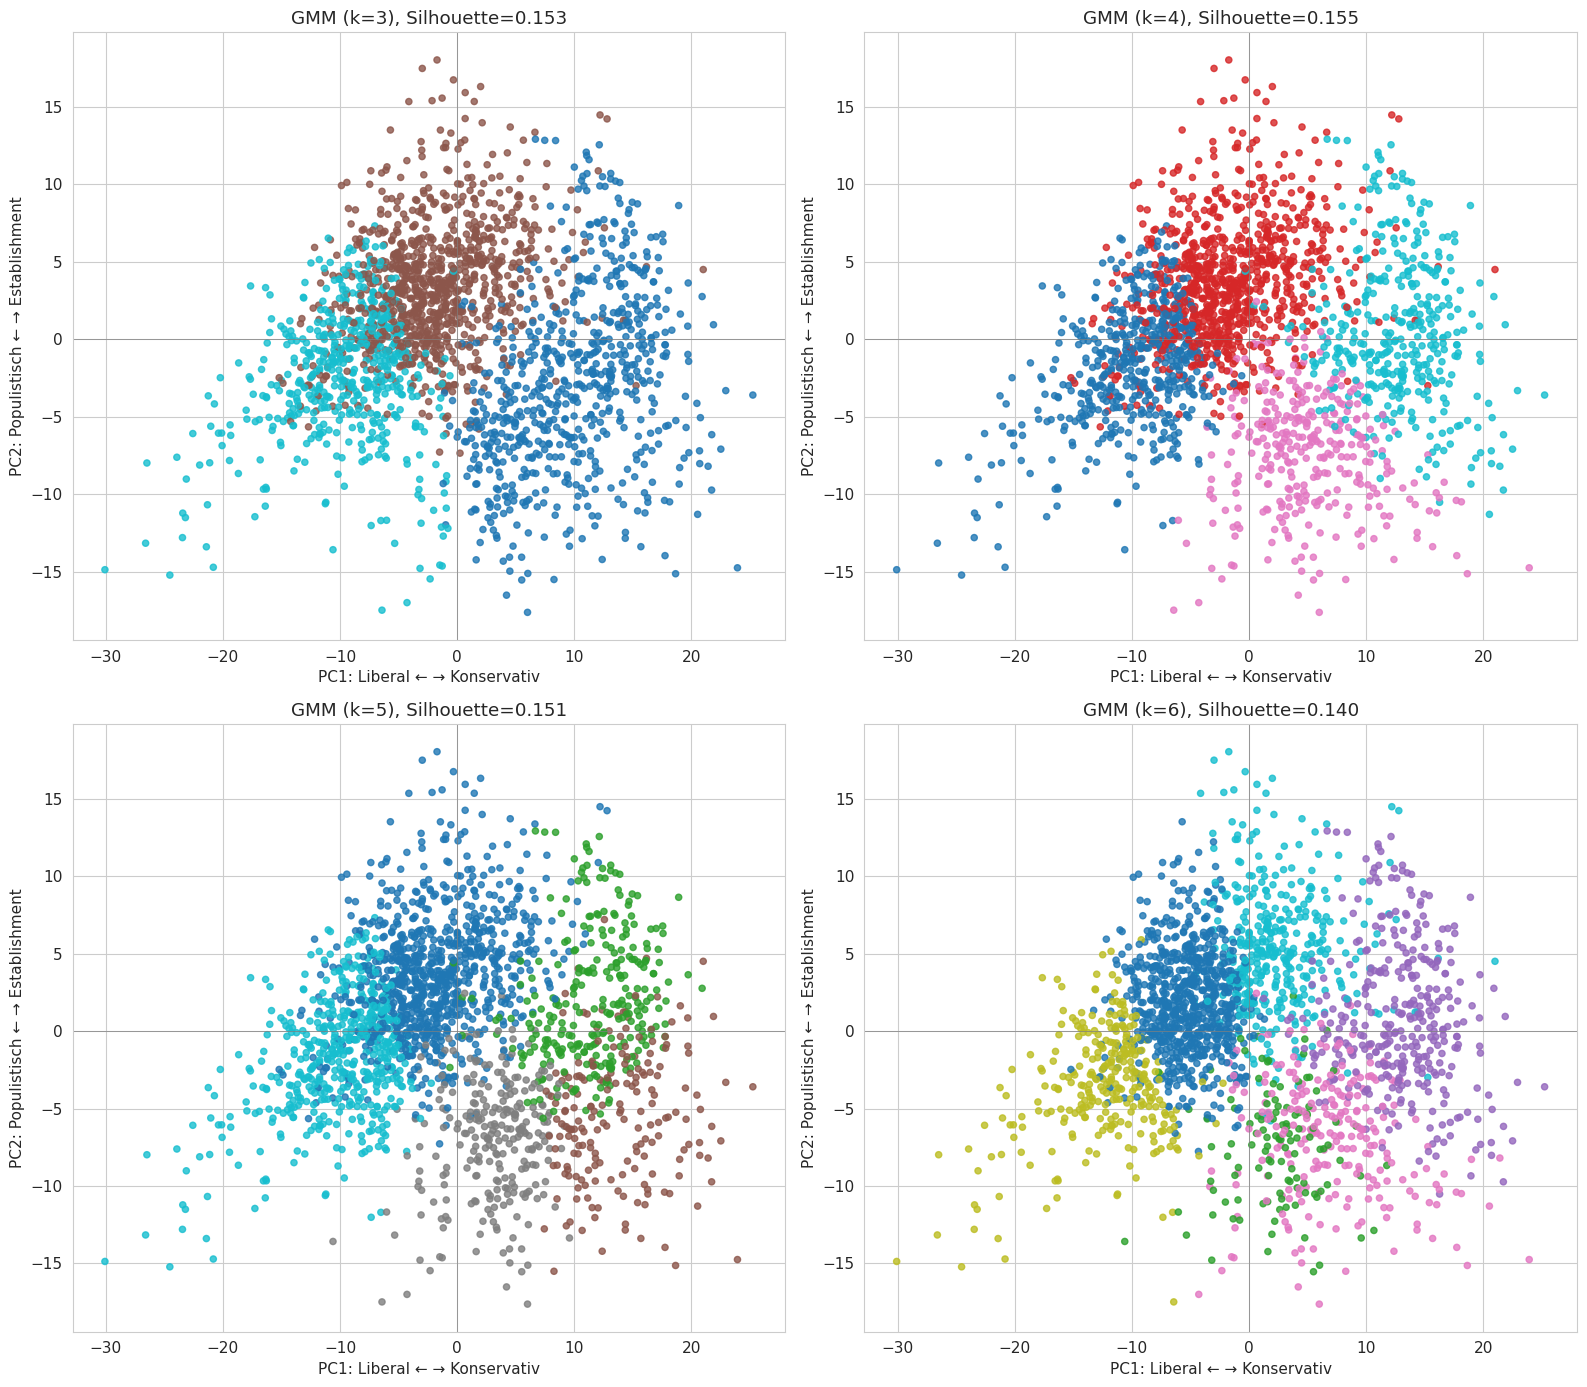

In [16]:
# GMM mit verschiedenen Komponentenzahlen
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

gmm_results = {}

for i, k in enumerate(k_values):
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=5)
    labels = gmm.fit_predict(X_scaled)
    probs = gmm.predict_proba(X_scaled)
    
    gmm_results[k] = {'labels': labels, 'probs': probs}
    sil = silhouette_score(X_scaled, labels)
    
    # Farbe nach Cluster, Transparenz nach Zugehörigkeits-Wahrscheinlichkeit
    max_probs = probs.max(axis=1)
    
    scatter = axes[i].scatter(
        df_pca['PC1'], df_pca['PC2'],
        c=labels, cmap='tab10', alpha=max_probs*0.8, s=20
    )
    axes[i].set_xlabel('PC1: Liberal ← → Konservativ')
    axes[i].set_ylabel('PC2: Populistisch ← → Establishment')
    axes[i].set_title(f'GMM (k={k}), Silhouette={sil:.3f}')
    axes[i].axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
    axes[i].axvline(x=0, color='gray', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('gmm_clustering.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
# GMM Detailanalyse
gmm_best = GaussianMixture(n_components=BEST_K, random_state=42, n_init=5)
df_pca['gmm_cluster'] = gmm_best.fit_predict(X_scaled)
df_pca['gmm_prob'] = gmm_best.predict_proba(X_scaled).max(axis=1)

print(f"GMM mit k={BEST_K}")
print(f"Silhouette Score: {silhouette_score(X_scaled, df_pca['gmm_cluster']):.3f}")
print(f"\nCluster-Grössen:")
print(df_pca['gmm_cluster'].value_counts().sort_index())

# Gemeinden mit unsicherer Zuordnung
uncertain = df_pca[df_pca['gmm_prob'] < 0.6]
print(f"\nGemeinden mit unsicherer Zuordnung (prob < 0.6): {len(uncertain)}")
if len(uncertain) > 0:
    print("Beispiele:")
    for _, row in uncertain.head(10).iterrows():
        print(f"  {row['municipality_name']} (prob={row['gmm_prob']:.2f})")

GMM mit k=4
Silhouette Score: 0.155

Cluster-Grössen:
gmm_cluster
0    528
1    866
2    328
3    387
Name: count, dtype: int64

Gemeinden mit unsicherer Zuordnung (prob < 0.6): 0


## 7. Vergleich der Methoden

In [18]:
# Vergleich der Clustering-Ergebnisse
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

methods = ['kmeans_cluster', 'hier_cluster', 'gmm_cluster']
method_names = ['K-Means', 'Hierarchisch', 'GMM']

# Wenn DBSCAN brauchbare Cluster hat, auch hinzufügen
if df_pca['dbscan_cluster'].nunique() > 2:
    methods.append('dbscan_cluster')
    method_names.append('DBSCAN')

print("="*70)
print("VERGLEICH DER CLUSTERING-METHODEN")
print("="*70)

# Metriken
print(f"\n{'Methode':<15} {'Silhouette':>12} {'Calinski-H':>12} {'Davies-B':>12}")
print("-"*55)

for method, name in zip(methods, method_names):
    labels = df_pca[method].values
    # Filter out noise for DBSCAN
    if 'dbscan' in method:
        mask = labels != -1
        if mask.sum() > len(set(labels[mask])):
            sil = silhouette_score(X_scaled[mask], labels[mask])
            cal = calinski_harabasz_score(X_scaled[mask], labels[mask])
            dav = davies_bouldin_score(X_scaled[mask], labels[mask])
        else:
            sil, cal, dav = 0, 0, 999
    else:
        sil = silhouette_score(X_scaled, labels)
        cal = calinski_harabasz_score(X_scaled, labels)
        dav = davies_bouldin_score(X_scaled, labels)
    
    print(f"{name:<15} {sil:>12.3f} {cal:>12.1f} {dav:>12.3f}")

# Übereinstimmung zwischen Methoden (Adjusted Rand Index)
print("\n" + "-"*55)
print("Adjusted Rand Index (Übereinstimmung zwischen Methoden):")
print("-"*55)

for i, (m1, n1) in enumerate(zip(methods[:-1], method_names[:-1])):
    for m2, n2 in zip(methods[i+1:], method_names[i+1:]):
        ari = adjusted_rand_score(df_pca[m1], df_pca[m2])
        print(f"  {n1} vs {n2}: {ari:.3f}")

VERGLEICH DER CLUSTERING-METHODEN

Methode           Silhouette   Calinski-H     Davies-B
-------------------------------------------------------
K-Means                0.167        457.6        1.884
Hierarchisch           0.158        410.4        1.957


GMM                    0.155        424.3        1.985

-------------------------------------------------------
Adjusted Rand Index (Übereinstimmung zwischen Methoden):
-------------------------------------------------------
  K-Means vs Hierarchisch: 0.573
  K-Means vs GMM: 0.793
  Hierarchisch vs GMM: 0.643


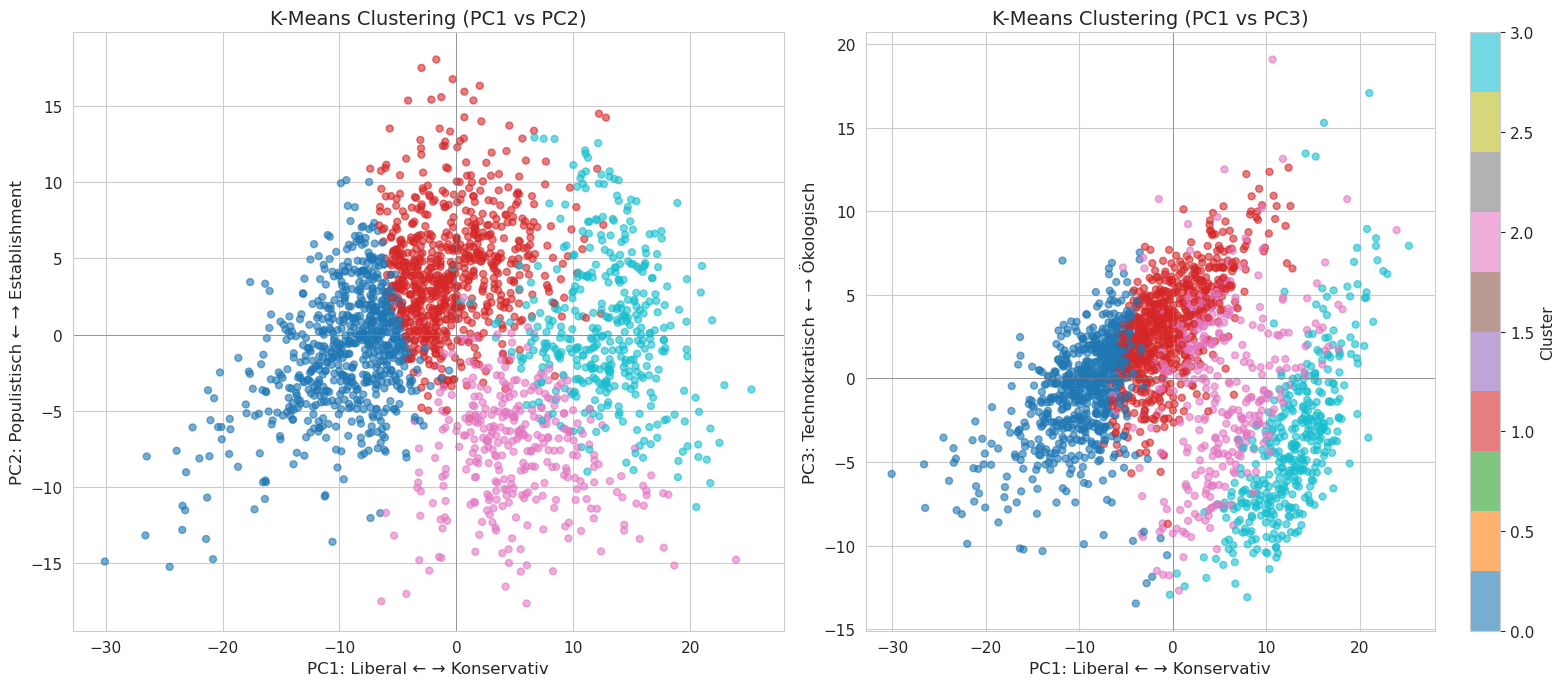

In [19]:
# Finale Visualisierung: Beste Methode
FINAL_METHOD = 'kmeans_cluster'  # Anpassen basierend auf Vergleich
FINAL_NAME = 'K-Means'

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# PC1 vs PC2
scatter = axes[0].scatter(
    df_pca['PC1'], df_pca['PC2'],
    c=df_pca[FINAL_METHOD], cmap='tab10', alpha=0.6, s=25
)
axes[0].set_xlabel('PC1: Liberal ← → Konservativ', fontsize=12)
axes[0].set_ylabel('PC2: Populistisch ← → Establishment', fontsize=12)
axes[0].set_title(f'{FINAL_NAME} Clustering (PC1 vs PC2)', fontsize=14)
axes[0].axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
axes[0].axvline(x=0, color='gray', linestyle='-', linewidth=0.5)

# PC1 vs PC3
scatter = axes[1].scatter(
    df_pca['PC1'], df_pca['PC3'],
    c=df_pca[FINAL_METHOD], cmap='tab10', alpha=0.6, s=25
)
axes[1].set_xlabel('PC1: Liberal ← → Konservativ', fontsize=12)
axes[1].set_ylabel('PC3: Technokratisch ← → Ökologisch', fontsize=12)
axes[1].set_title(f'{FINAL_NAME} Clustering (PC1 vs PC3)', fontsize=14)
axes[1].axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
axes[1].axvline(x=0, color='gray', linestyle='-', linewidth=0.5)

# Colorbar
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('Cluster')

plt.tight_layout()
plt.savefig('final_clustering.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Cluster-Profile

In [20]:
# Cluster-Profile basierend auf PCA-Koordinaten
print("="*80)
print("CLUSTER-PROFILE")
print("="*80)

for cluster in sorted(df_pca[FINAL_METHOD].unique()):
    if cluster == -1:
        continue  # Skip noise
    
    members = df_pca[df_pca[FINAL_METHOD] == cluster]
    
    print(f"\n{'-'*60}")
    print(f"CLUSTER {cluster} ({len(members)} Gemeinden)")
    print(f"{'-'*60}")
    
    # Mittlere PCA-Koordinaten
    pc1_mean = members['PC1'].mean()
    pc2_mean = members['PC2'].mean()
    pc3_mean = members['PC3'].mean()
    
    # Interpretation
    lib_kon = "LIBERAL" if pc1_mean > 5 else ("KONSERVATIV" if pc1_mean < -5 else "moderat")
    est_pop = "ESTABLISHMENT" if pc2_mean > 5 else ("POPULISTISCH" if pc2_mean < -5 else "gemischt")
    oeko_tech = "ÖKOLOGISCH" if pc3_mean > 3 else ("TECHNOKRATISCH" if pc3_mean < -3 else "neutral")
    
    print(f"  Mittlere Koordinaten:")
    print(f"    PC1 (Lib-Kon): {pc1_mean:+.1f} → {lib_kon}")
    print(f"    PC2 (Est-Pop): {pc2_mean:+.1f} → {est_pop}")
    print(f"    PC3 (Öko-Tec): {pc3_mean:+.1f} → {oeko_tech}")
    
    # Typische Gemeinden (nahe am Zentroid)
    members = members.copy()
    members['dist'] = np.sqrt(
        (members['PC1'] - pc1_mean)**2 + 
        (members['PC2'] - pc2_mean)**2 +
        (members['PC3'] - pc3_mean)**2
    )
    
    print(f"  \n  Typische Gemeinden:")
    for _, row in members.nsmallest(8, 'dist').iterrows():
        print(f"    - {row['municipality_name']}")

CLUSTER-PROFILE

------------------------------------------------------------
CLUSTER 0 (673 Gemeinden)
------------------------------------------------------------
  Mittlere Koordinaten:
    PC1 (Lib-Kon): -9.5 → KONSERVATIV
    PC2 (Est-Pop): -1.1 → gemischt
    PC3 (Öko-Tec): -0.7 → neutral
  
  Typische Gemeinden:
    - Oberegg
    - Seelisberg
    - Merishausen
    - Laupersdorf
    - Pfäfers
    - Wimmis
    - Schattdorf
    - Arni (BE)

------------------------------------------------------------
CLUSTER 1 (717 Gemeinden)
------------------------------------------------------------
  Mittlere Koordinaten:
    PC1 (Lib-Kon): -0.4 → moderat
    PC2 (Est-Pop): +4.2 → gemischt
    PC3 (Öko-Tec): +3.1 → ÖKOLOGISCH
  
  Typische Gemeinden:
    - Thusis
    - Riedholz
    - Wangen bei Olten
    - Büren an der Aare
    - Fürstenau
    - Neuenegg
    - Buchs (AG)
    - Zeiningen

------------------------------------------------------------
CLUSTER 2 (329 Gemeinden)
---------------------

## 9. Export der Ergebnisse

In [21]:
# Export der Cluster-Zuordnungen
export_df = df_pca[['municipality_id', 'municipality_name', 'PC1', 'PC2', 'PC3',
                    'kmeans_cluster', 'hier_cluster', 'gmm_cluster', 'dbscan_cluster']].copy()

export_df.to_csv('municipality_clusters.csv', index=False)
print("Cluster-Zuordnungen exportiert nach: municipality_clusters.csv")

# Zusammenfassung
print("\n" + "="*60)
print("ZUSAMMENFASSUNG")
print("="*60)
print(f"\nDatenbasis: {len(df_pca)} Gemeinden, {df_imputed.shape[1]} Abstimmungen")
print(f"\nGetestete Methoden:")
print(f"  - K-Means (k={BEST_K})")
print(f"  - Hierarchisch Ward (k={BEST_K})")
print(f"  - DBSCAN (eps={BEST_EPS})")
print(f"  - Gaussian Mixture (k={BEST_K})")
print(f"\nVisualisierung: Im PCA-Raum (3 Dimensionen)")

Cluster-Zuordnungen exportiert nach: municipality_clusters.csv

ZUSAMMENFASSUNG

Datenbasis: 2109 Gemeinden, 223 Abstimmungen

Getestete Methoden:
  - K-Means (k=4)
  - Hierarchisch Ward (k=4)
  - DBSCAN (eps=12)
  - Gaussian Mixture (k=4)

Visualisierung: Im PCA-Raum (3 Dimensionen)


In [22]:
# Datenbankverbindung schliessen
conn.close()
print("Analyse abgeschlossen.")

Analyse abgeschlossen.
